# Amplitude embedding (hardware)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = 1 #np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 3.01697408e-03-1.9844056e-03j  5.06652603e+01+3.2004372e+01j
   2.67517624e+01+8.7557673e-01j -5.23214461e-04-2.4964449e-03j]
 [ 1.14364866e-02-1.2032130e-03j -1.16554191e-02-2.8017987e-03j
   1.78433132e+01+3.8398502e+01j  1.38068935e-02+5.7136551e-03j]
 [ 1.23696213e+01+8.5287848e+00j  3.59714317e+01+7.7261848e+00j
  -1.72674339e-02+4.6874015e-03j  8.19844753e-03+2.0843055e-02j]
 [ 1.46846995e-02-3.2687488e-03j  9.36952885e-03-1.3485289e-02j
   1.13869552e-02-1.1810326e-02j  7.38306844e-04+7.2180647e-03j]]


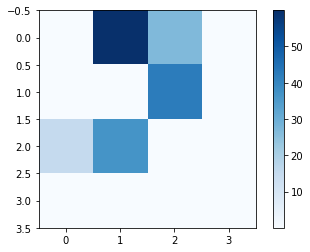

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 143.64458  +87.534836j     7.492555-117.35681j
   -29.668673  +8.043736j   -71.87343  +55.867558j ]
 [  67.50909   -1.2257543j  -53.20826   -6.2812223j
    38.120518 -49.75136j   -101.8795   +23.148254j ]
 [ 107.85842  +10.777102j    43.208153 -40.608147j
   -65.4058   -68.72742j    -36.274708+132.68355j  ]
 [  -9.334024 +34.415688j    23.540047 -41.927197j
   -38.68588  -14.078093j   -24.99482  -12.546471j ]]


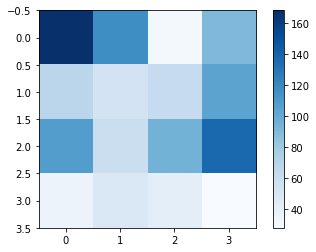

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [6]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.9677619e-13
Imaginaries MSE: 1.08866183e-13


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [7]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

# normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qbits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires, shots=1) # hardware (MOTIVATION?)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

ValueError: probabilities do not sum to 1

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')